**MASTER'S DEGREE IN APPLIED ARTIFICIAL INTELLIGENCE**.

**Course: TC5035.10 - Integration project**

Tecnológico de Monterrey

Professor Dr. Horacio Martínez Alfaro

**Week 3, Activity 2**

Characteristics engineering

---

*   **Student:** Jorge Antonio Acosta Rosales
*   **Registration:** A01381552
*   **Student:** Israel Luján González
*   **Registration:** A01794693

Loading libraries for this project.

**Note:** we use uv tool to administrate the dependencies of the project
use the command below to install the dependencies
```bash
uv sync

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

In [2]:
# Load variables from .env file for local development or get it from the environment variables in production
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # Safe fallback if it's not available in prod

base_path = os.getenv("LSM_BASE")
if not base_path:
    raise ValueError("❌ Environment variable 'LSM_BASE' is not set!")

gestures_csv_path = os.path.join(base_path, "data", "processed", "metadata", "gestures_flat.csv")

In [3]:
# Load CSV file
gestures_raw_df = pd.read_csv(gestures_csv_path)

print("Summary of the datatypes and the values in the gestures dataset:")
display(gestures_raw_df.head())

Summary of the datatypes and the values in the gestures dataset:


,file_name,label,width,height,hand_count,hadedness_left,hadedness_right,confidence_left,confidence_right,right_x0,...,left_z17,left_x18,left_y18,left_z18,left_x19,left_y19,left_z19,left_x20,left_y20,left_z20
0,A_b9b32d87.jpg,A,640,640,1,0,1,NaN,0.997785,0.798897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A_d2b5d17d.jpg,A,640,640,1,0,1,NaN,0.997479,0.381789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A_9ff361f9.jpg,A,640,640,1,1,0,0.987826,NaN,NaN,...,-0.061392,0.71582,0.278875,-0.096776,0.671791,0.374887,-0.068303,0.657775,0.440908,-0.035481
3,A_e7bea9a5.jpg,A,640,640,1,0,1,NaN,0.985266,0.439434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A_750b0c55.jpg,A,640,640,1,0,1,NaN,0.984593,0.271182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


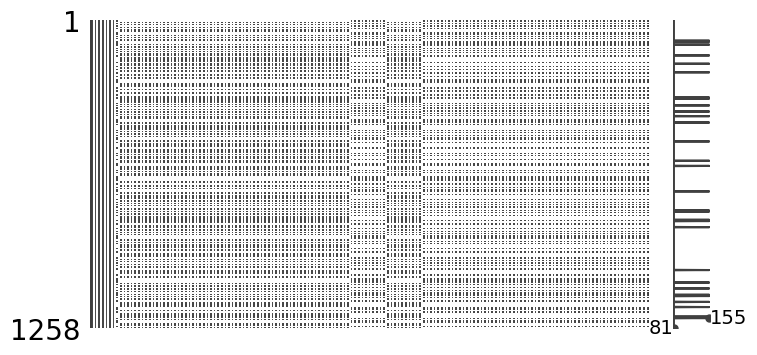

In [4]:
# Visualize missingness:
import missingno as msno
msno.matrix(gestures_raw_df, figsize=(8,4))
plt.show()

# Cleaning Process

We begin the dataset cleaning phase using the insights obtained during our EDA. As previously noted, our capture setup records only one hand gesture per image, but an image may contain one or two hands. Therefore, we need to filter the records to retain just the most reliable hand instance in each frame. Although MediaPipe can be configured to detect only a single hand, we choose to apply this filtering manually to avoid discarding potentially valuable data—and to ensure that, if we later develop support for two‐hand processing, our core pipeline requires minimal changes.

This step is not a data transformation but rather a cleaning stage. First, we select the hand with the highest detection confidence. Then, we normalize the dataset by standardizing column names across all features. By enforcing consistent naming conventions, we make our workflow more ergonomic and our subsequent transformations clearer.


In [5]:
df = gestures_raw_df.copy()

# Replace NaNs in confidence with 0 so comparisons won’t break
df['confidence_left_f']  = df['confidence_left'].fillna(0)
df['confidence_right_f'] = df['confidence_right'].fillna(0)

# Decide which hand “wins” (higher confidence)
df['preferred_hand'] = np.where(
    df['confidence_left_f'] >= df['confidence_right_f'],
    'left',
    'right'
)

# Starting new DataFrame with the columns we still want
cols_to_keep = ['file_name','label','width','height','hand_count']
gestures_df = df[cols_to_keep].copy()

# Unified handedness & confidence
gestures_df['handedness'] = df['preferred_hand']
gestures_df['confidence']  = np.where(
    df['preferred_hand']=='left',
    df['confidence_left'],
    df['confidence_right']
)

# Pull in the 21 landmarks for whichever side was chosen
for axis in ('x','y','z'):
    for i in range(21):
        left_col  = f'left_{axis}{i}'
        right_col = f'right_{axis}{i}'
        new_col   = f'{axis}{i}'
        # choose left_<axis><i> if preferred_hand=='left', else right_<axis><i>
        gestures_df[new_col] = np.where(
            df['preferred_hand']=='left',
            df[left_col],
            df[right_col]
        )

# Pull in engineered distances & angles for just the winning hand
fingers = ["thumb","index","middle","ring","pinky"]
for finger in fingers:
    # distance feature
    gestures_df[f"{finger}_dist"] = np.where(
        df['preferred_hand']=='left',
        df[f'left_{finger}_dist'],
        df[f'right_{finger}_dist']
    )
    # angle feature
    gestures_df[f"{finger}_angle"] = np.where(
        df['preferred_hand']=='left',
        df[f'left_{finger}_angle'],
        df[f'right_{finger}_angle']
    )

# Keep only rows with hand_count not equal to 2
gestures_df = gestures_df[gestures_df['hand_count'] != 2].reset_index(drop=True)

In [6]:
gestures_df.head()

,file_name,label,width,height,hand_count,handedness,confidence,x0,x1,x2,...,thumb_dist,thumb_angle,index_dist,index_angle,middle_dist,middle_angle,ring_dist,ring_angle,pinky_dist,pinky_angle
0,A_b9b32d87.jpg,A,640,640,1,right,0.997785,0.798897,0.725475,0.570459,...,0.615069,162.072725,0.428294,149.142996,0.400321,154.507508,0.375774,160.232554,0.366992,163.426065
1,A_d2b5d17d.jpg,A,640,640,1,right,0.997479,0.381789,0.559909,0.685032,...,0.621105,162.560841,0.425830,148.724763,0.398358,155.136401,0.374649,161.810152,0.365546,165.570584
2,A_9ff361f9.jpg,A,640,640,1,left,0.987826,0.606538,0.442157,0.319858,...,0.611691,163.256617,0.438740,148.753663,0.392533,154.831782,0.359303,158.650349,0.356963,160.237081
3,A_e7bea9a5.jpg,A,640,640,1,right,0.985266,0.439434,0.591480,0.702281,...,0.568575,154.395800,0.312348,130.816186,0.270621,131.528817,0.273953,142.488172,0.313761,154.101684
4,A_750b0c55.jpg,A,640,640,1,right,0.984593,0.271182,0.331742,0.484159,...,0.570004,155.083940,0.312544,130.410206,0.271806,131.407179,0.275288,142.368124,0.316213,154.106598


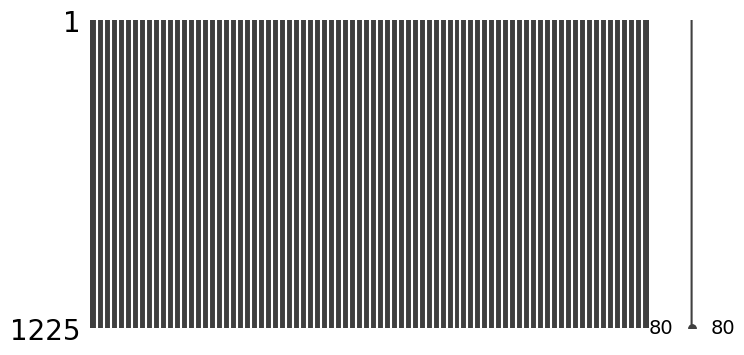

In [7]:
msno.matrix(gestures_df, figsize=(8,4))
plt.show()

As we discussed in the EDA, the columns of width, height and hand_count for now are not usful and don't apport any information to the model, so we will drop them.

In [8]:
gestures_df.drop(columns=['file_name', 'width', 'height', 'hand_count'], inplace=True)

In [9]:
# Updating numerical columns and categorical
numerical_columns = gestures_df.select_dtypes(include = ['int', 'float']).columns
categorical_columns = gestures_df.select_dtypes(include = ['object','category']).columns

print("Numerical columns: ", numerical_columns.to_list())
print("Categorical columns: ", categorical_columns.to_list())
print(f"Number of numerical columns: {len(numerical_columns)}")
print(f"Number of categorical columns: {len(categorical_columns)}")  

Numerical columns:  ['confidence', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20', 'z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14', 'z15', 'z16', 'z17', 'z18', 'z19', 'z20', 'thumb_dist', 'thumb_angle', 'index_dist', 'index_angle', 'middle_dist', 'middle_angle', 'ring_dist', 'ring_angle', 'pinky_dist', 'pinky_angle']
Categorical columns:  ['label', 'handedness']
Number of numerical columns: 74
Number of categorical columns: 2


**Note:** It is necessary to emphasize that if you see what is done in the script of `getting_metadata.py` is previously made a nesting of new data in the category of `enginnered` in which are included the disntancias of the fingers and the angles of the same with respect to the wrist, this is done so that the model can learn in a more efficient way and not only with the original data. This was proposed by our team thanks to a research work where other universities when facing a similar challenge, showed that having this type of data helps to improve the accuracy of the trained models.

Now we are going to show the distribution of the data and based on that we will take the best decision for the normalization of the data, as well as the reduction of the same since the EDA showed that the correlation of many is redundant and can reduce the performance of the model.

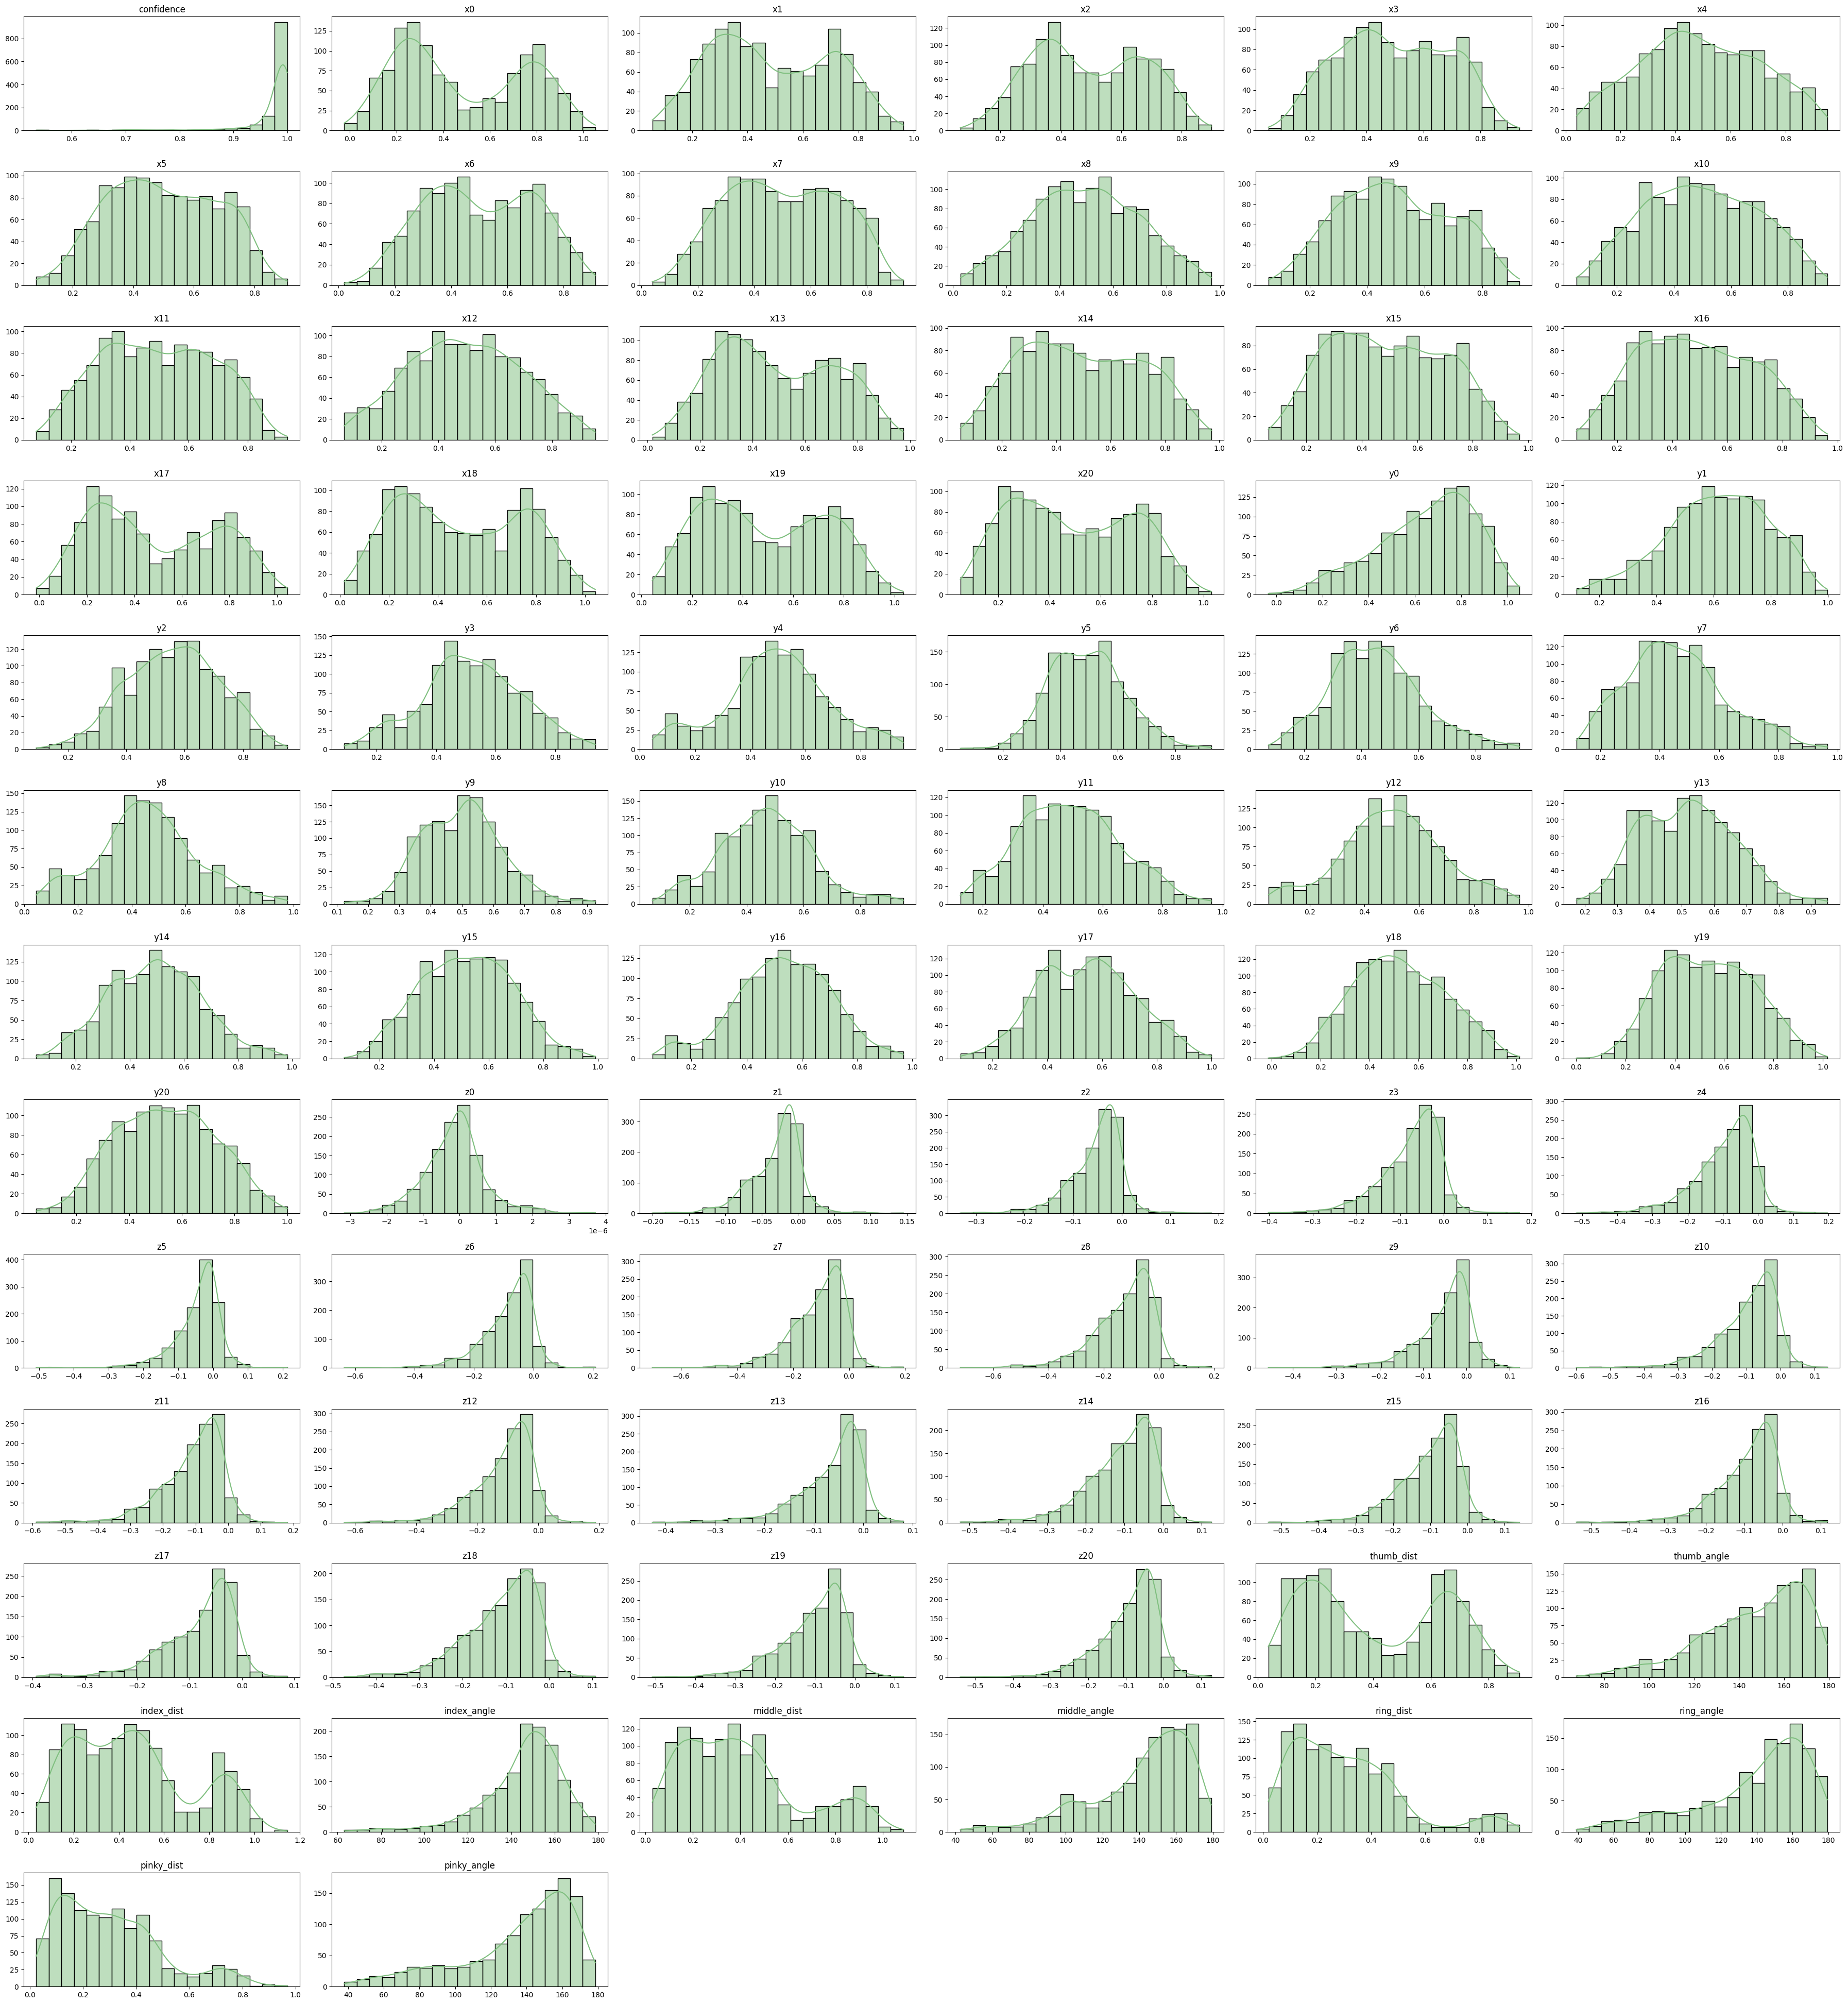

In [10]:
# Compute grid size
n = len(numerical_columns)
ncols = 6
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
axes = axes.flatten()

# Plot each histogram
for ax, col in zip(axes, numerical_columns):
    sns.histplot(gestures_df[col].dropna(), kde=True, bins=20, ax=ax, color='#7fbf7f')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Turn off any unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data Review and Processing Plan

## 1. Confidence

Detection confidence ranges from about 0.55 to 1.0, but the vast majority of samples cluster between 0.9 and 1.0. With such minimal variance—and given our limited dataset size—this column contributes almost no discriminative power. We will drop it for now; if we later collect more data, we can revisit including confidence in the model.

## 2. X-Coordinate Landmarks (`x0…x20`)

All X values lie in \[0, 1], confirming they’re already normalized horizontally. Many joints and fingertips show clear bi- or multi-modal distributions—gestures naturally group points toward the left (≈0.2–0.4) or right (≈0.6–0.8) of the frame. These patterns encode semantic differences between signs. Because they share a common scale, we won’t re‐normalize them, but we will rely on PCA later to reduce redundancy across the 21 coordinates.

## 3. Y-Coordinate Landmarks (`y0…y20`)

Y values also fall within \[0, 1] and form roughly bell-shaped curves (means around 0.5–0.7). This reflects that most hand positions appear in the lower half of the image. The modest skew and unimodal shape mean they don’t require any nonlinear transform before scaling.

## 4. Z-Coordinate Landmarks (`z0…z20`)

Depth coordinates center near zero but display a pronounced right-tail of positive values. Although these raw values are small, their skew suggests a mild transformation could help—especially if depth proves predictive. We will apply a Yeo–Johnson PowerTransformer to symmetrize these distributions.

## 5. Engineered Features (`*_dist`, `*_angle`)

Distance and angle features show varied, often long-tailed or multimodal patterns. A PowerTransformer will reduce skew across all 10 distance and 10 angle columns, making them more Gaussian-like. After transformation, we will scale them to \[0, 1] alongside the coordinates.

## 6. Outlier and Artifact Handling

A few coordinate values fall just below 0 or exceed 1—clear detection artifacts. We will clip all X, Y, and Z values to the valid \[0, 1] range before scaling, ensuring no impossible values slip into the model.

---

# Preprocessing Decisions

1. **Drop low-variance `confidence`**
   Remove this column entirely to avoid adding noise.

2. **PowerTransform skewed features**
   Apply the Yeo–Johnson `PowerTransformer` to:

   * All Z-coordinate columns (`z0…z20`)
   * All distance features (`*_dist`)
   * All angle features (`*_angle`)

3. **Clip coordinates to \[0, 1]**
   Enforce valid bounds on X, Y, and Z before scaling.

4. **MinMax scale all numerical columns**
   Rescale every remaining numeric feature to the \[0, 1] interval.

5. **Dimensionality reduction with PCA**
   Run PCA on the scaled feature matrix, retaining components that explain 95 % of the total variance.


## Justification of Processing Steps

1. **Drop the `confidence` column**

   * **Why?** The “confidence” histogram shows an extreme spike at 1.0 and almost no spread elsewhere. With near-zero variance, it carries virtually no information for the model—and risks numerical issues—so we remove it.

2. **PowerTransform (Yeo–Johnson) on skewed features**

   * **Which features?**

     * Z-coordinates (`z0…z20`): all heavily skewed, often clustered near 0 or extreme values.
     * Distance features (`*_dist`): distributions vary wildly—some multimodal, some long-tailed.
     * Angle features (`*_angle`): often right-skewed, with peaks near anatomical limits (0° or 180°).
   * **Why?** The PowerTransformer “Gaussianizes” skewed data, making subsequent scaling and PCA more effective and stabilizing variance across features.

3. **MinMax scaling to $0, 1$**

   * **Why?** After transformation, features still live on different numeric ranges (angles in degrees vs. normalized coordinates). Scaling everything to $0, 1$

     * Puts all features on a comparable scale for models sensitive to magnitude.
     * Preserves relative shapes of the now–more symmetric distributions.

4. **PCA to retain 95 % of variance**

   * **Why?** We started with dozens of raw (63 coordinate) + engineered (10 distances + 10 angles) features.
   * PCA

     * **Reduces dimensionality**—faster training, lower overfitting risk.
     * **Keeps 95 % of the total variance**, ensuring you don’t throw away the bulk of your signal.
     * Produces orthogonal components that simplify downstream algorithms.

---

Each step follows directly from what the histograms reveal:

* The **flat line at 1.0** for confidence ⇒ drop it.
* The **long tails** in z, distance, angle plots ⇒ PowerTransform.
* The **mixed numeric ranges** post-transform ⇒ MinMax scaling.
* The **high feature count** with overlapping information ⇒ PCA.

This pipeline ensures your final feature matrix is well-behaved, on a uniform scale, and compact—ideal for robust model training.


# Categorical variables and processing

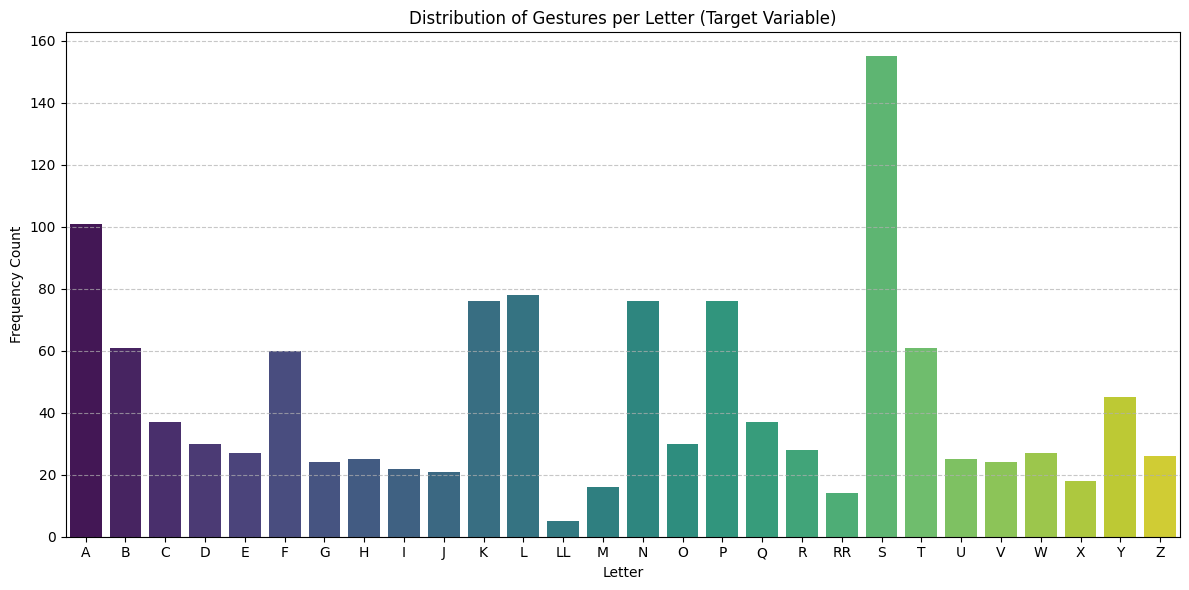

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=gestures_df, x='label', hue='label', palette='viridis')

plt.title('Distribution of Gestures per Letter (Target Variable)')
plt.xlabel('Letter')
plt.ylabel('Frequency Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

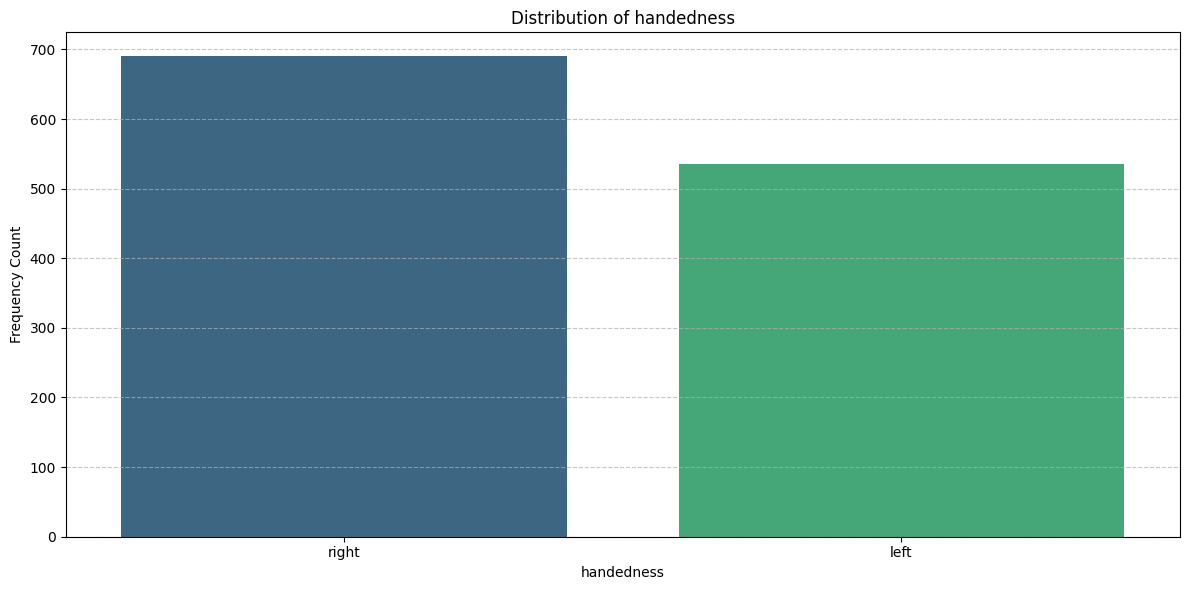

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=gestures_df, x='handedness', hue='handedness', palette='viridis')

plt.title('Distribution of handedness')
plt.xlabel('handedness')
plt.ylabel('Frequency Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Based in this information we mantain the same recomendations that we did in the EDA activity, we have a big problem of class imbalance, and the data argumentation is not a good option because a great majority of our images are already augmented, so we are going to try to use the SMOTE algorithm to balance the data, in review the results, if is not good enough we can try other methods like ADASYN or BorderlineSMOTE.

# SMOTE
**Why?** Its proved that this algorithm is one of the best for this kind of problems, and is the most used in the industry. However, we will try to use the `k_neighbors` parameter to see if we can get better results, and also the `sampling_strategy` parameter to see if we can get a better balance between the classes.

---

# Transformation process

---



In [13]:
# As we said earlier, we have to delete the confidence column and then map the other categorical column to 0 and 1 to get ready
# the dataset for the transformation process.
gestures_df.drop(columns=['confidence'], inplace=True)
gestures_df["handedness"] = gestures_df["handedness"].map({"left": 0, "right": 1})

In [14]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# Defining the columns to be transformed
z_cols = [f'z{i}' for i in range(21)]
dist_cols = [col for col in gestures_df.columns if col.endswith('_dist')]
angle_cols = [col for col in gestures_df.columns if col.endswith('_angle')]

cols_to_transform = z_cols + dist_cols + angle_cols

# Apply PowerTransformer to Z axes, distances, and angles
pt = PowerTransformer(method='yeo-johnson')
gestures_df[cols_to_transform] = pt.fit_transform(gestures_df[cols_to_transform])

# Apply MinMaxScaler to all of our numerical columns
numerical_columns = gestures_df.select_dtypes(include=['int', 'float']).columns
scaler = MinMaxScaler()
gestures_df[numerical_columns] = scaler.fit_transform(gestures_df[numerical_columns])

In [15]:
categorical_columns = gestures_df.select_dtypes(include = ['object','category']).columns
print("Numerical columns: ", numerical_columns.to_list())
print("Categorical columns: ", categorical_columns.to_list())


Numerical columns:  ['handedness', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20', 'z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14', 'z15', 'z16', 'z17', 'z18', 'z19', 'z20', 'thumb_dist', 'thumb_angle', 'index_dist', 'index_angle', 'middle_dist', 'middle_angle', 'ring_dist', 'ring_angle', 'pinky_dist', 'pinky_angle']
Categorical columns:  ['label']


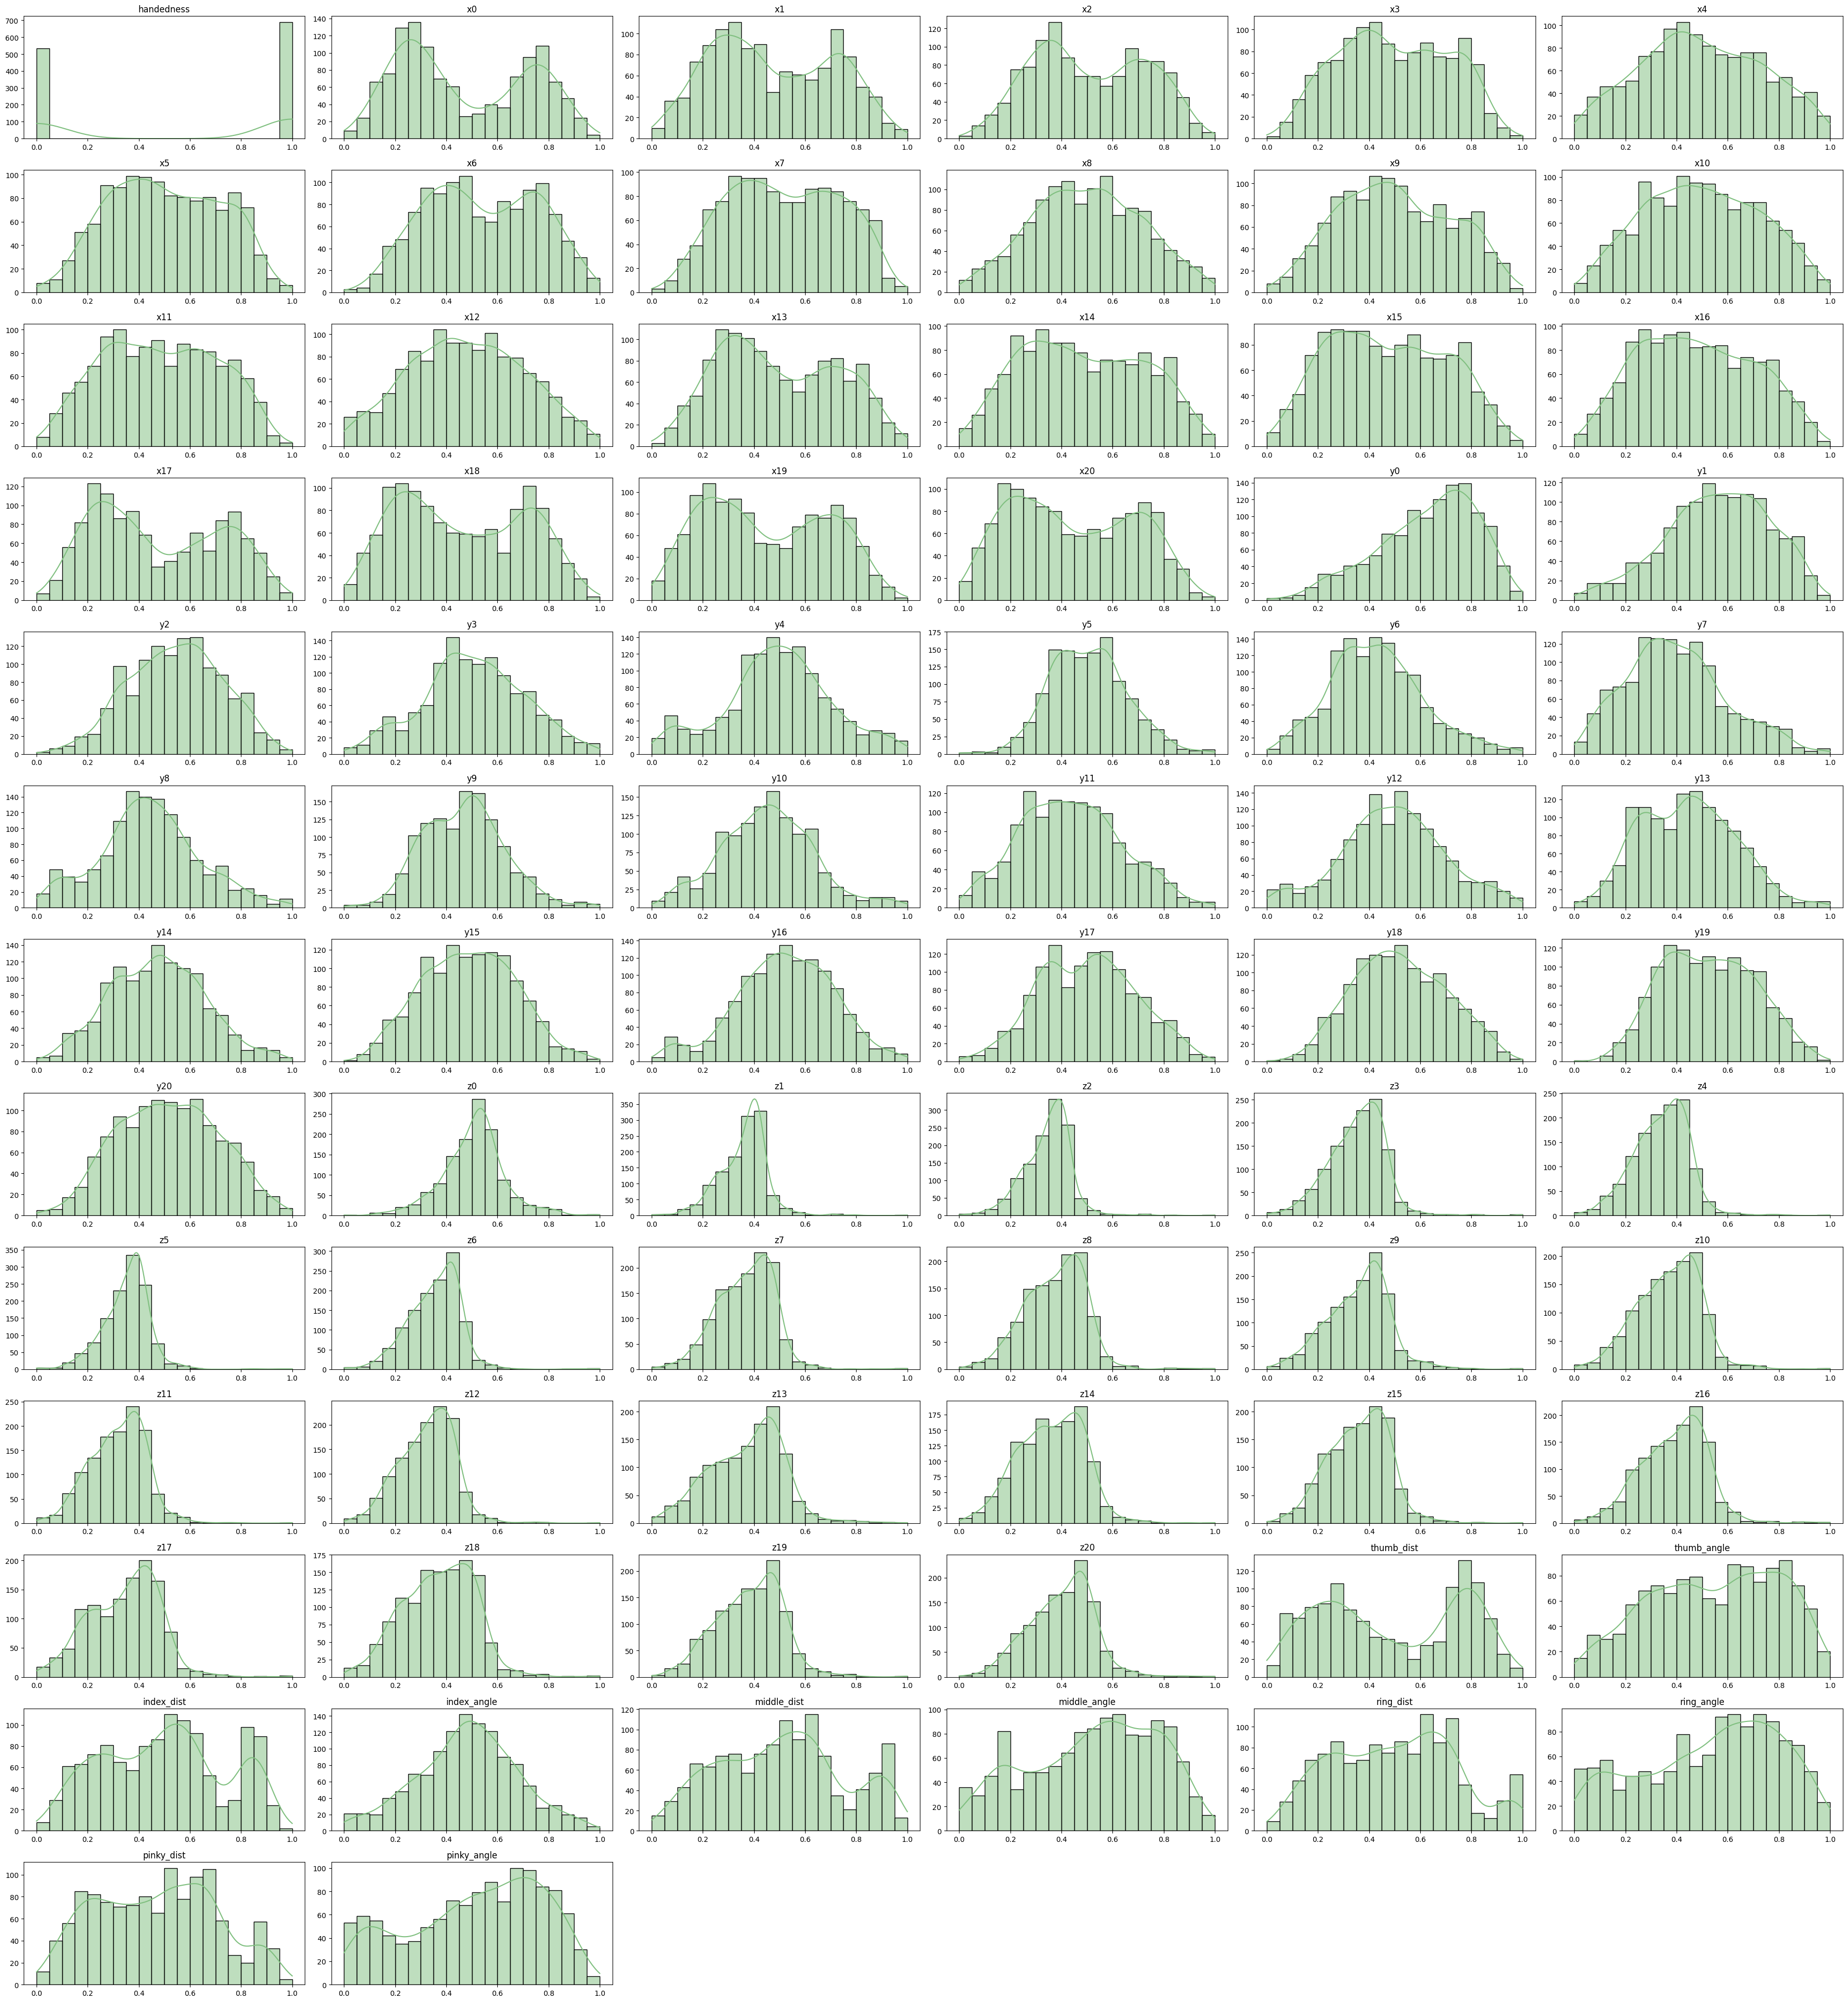

In [16]:
# Compute grid size
n = len(numerical_columns)
ncols = 6
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
axes = axes.flatten()

# Plot each histogram
for ax, col in zip(axes, numerical_columns):
    sns.histplot(gestures_df[col].dropna(), kde=True, bins=20, ax=ax, color='#7fbf7f')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Turn off any unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

The transformation process with powerTransform and MinMaxScaler indeed create a new dataset with better distributions and ranges for the features. Now we are going to use PCA to reduce the dimensionality of the dataset and keep 95% of the variance. This will help us to reduce the complexity of the model, remove noise, and improve the performance of the model

In [17]:
# Extracting all the independent variables
X = gestures_df[numerical_columns]

In [18]:
from sklearn.decomposition import PCA

# Applying PCA to reduce dimensionality having 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)


In [19]:
print(f"Number of components retained: {pca.n_components_}")
print(f"Cumulative percentage of variance explained: {sum(pca.explained_variance_ratio_):.2%}")


Number of components retained: 15
Cumulative percentage of variance explained: 95.45%


In [20]:
pca_cols = [f'PC{i+1}' for i in range(pca.n_components_)]
gestures_pca_df = pd.DataFrame(X_pca, columns=pca_cols)

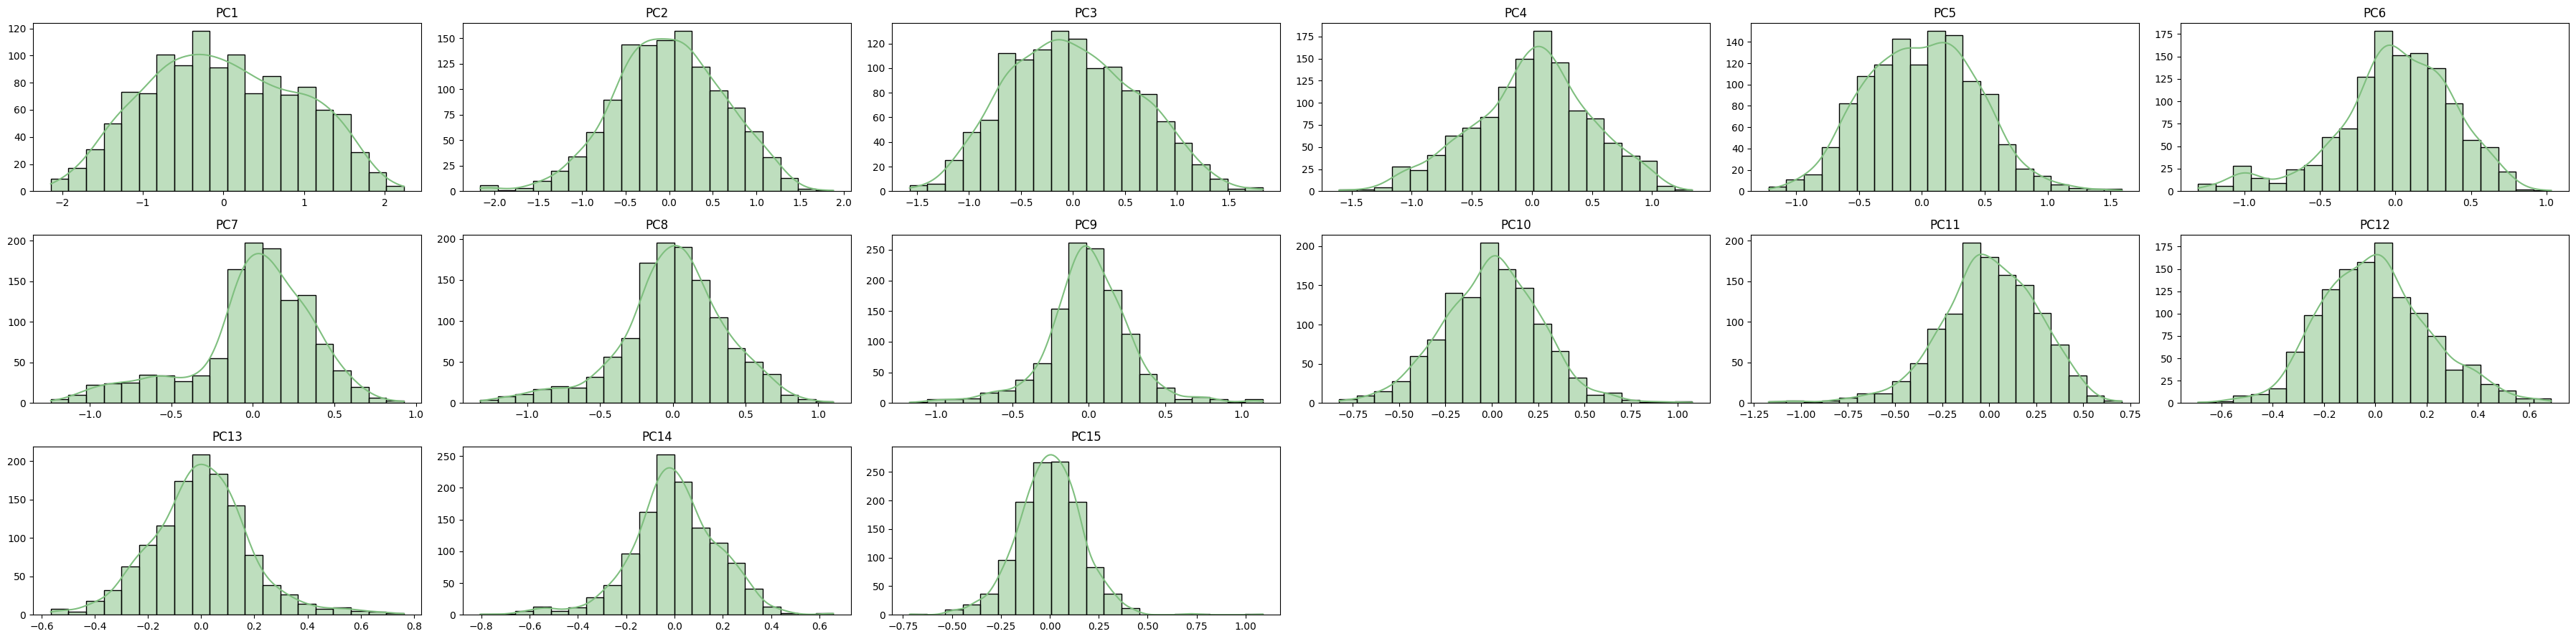

In [21]:
numerical_columns = gestures_pca_df.select_dtypes(include = ['int', 'float']).columns
# Compute grid size
n = len(numerical_columns)
ncols = 6
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
axes = axes.flatten()

# Plot each histogram
for ax, col in zip(axes, numerical_columns):
    sns.histplot(gestures_pca_df[col].dropna(), kde=True, bins=20, ax=ax, color='#7fbf7f')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Turn off any unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

As we can see the transformation process efectively reduced the number of features from 63 to 15 and mantain the essence of the data, the following step is to get more samples using this information applying the SMOTE algorithm to balance the dataset and then train the model with this new dataset.

In [ ]:
from imblearn.over_sampling import SMOTE

X = gestures_pca_df
y = gestures_df['label']

smote = SMOTE(random_state=42, k_neighbors=2)

X_resampled, y_resampled = smote.fit_resample(X, y)

df_balanced = pd.DataFrame(X_resampled, columns=gestures_pca_df.columns)
df_balanced['label'] = y_resampled


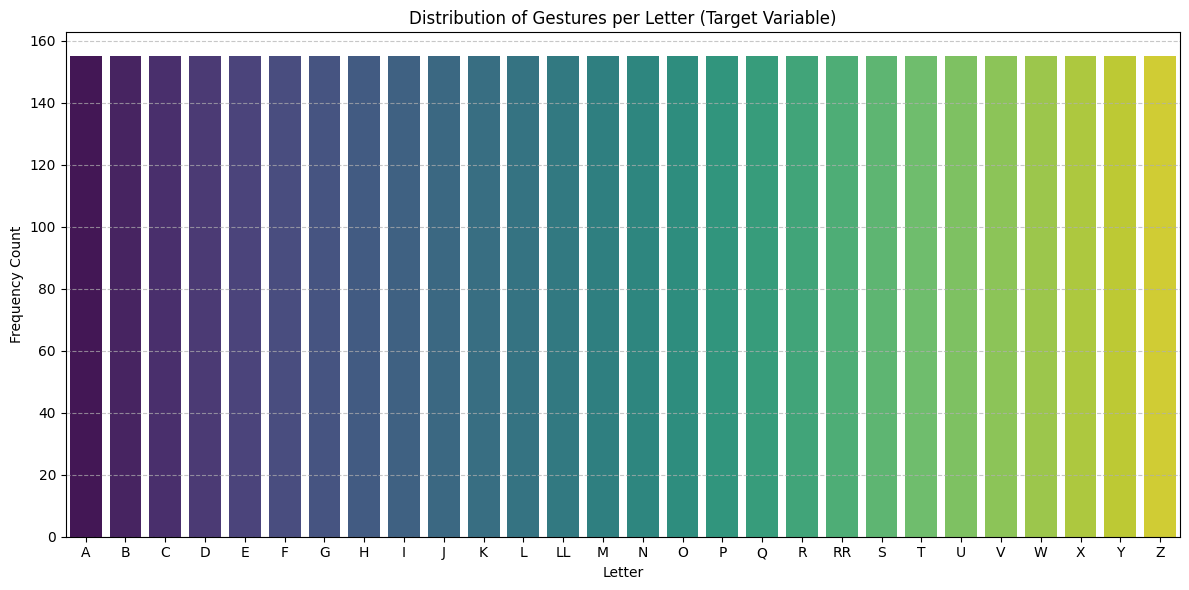

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_balanced, x='label', hue='label', palette='viridis')

plt.title('Distribution of Gestures per Letter (Target Variable)')
plt.xlabel('Letter')
plt.ylabel('Frequency Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

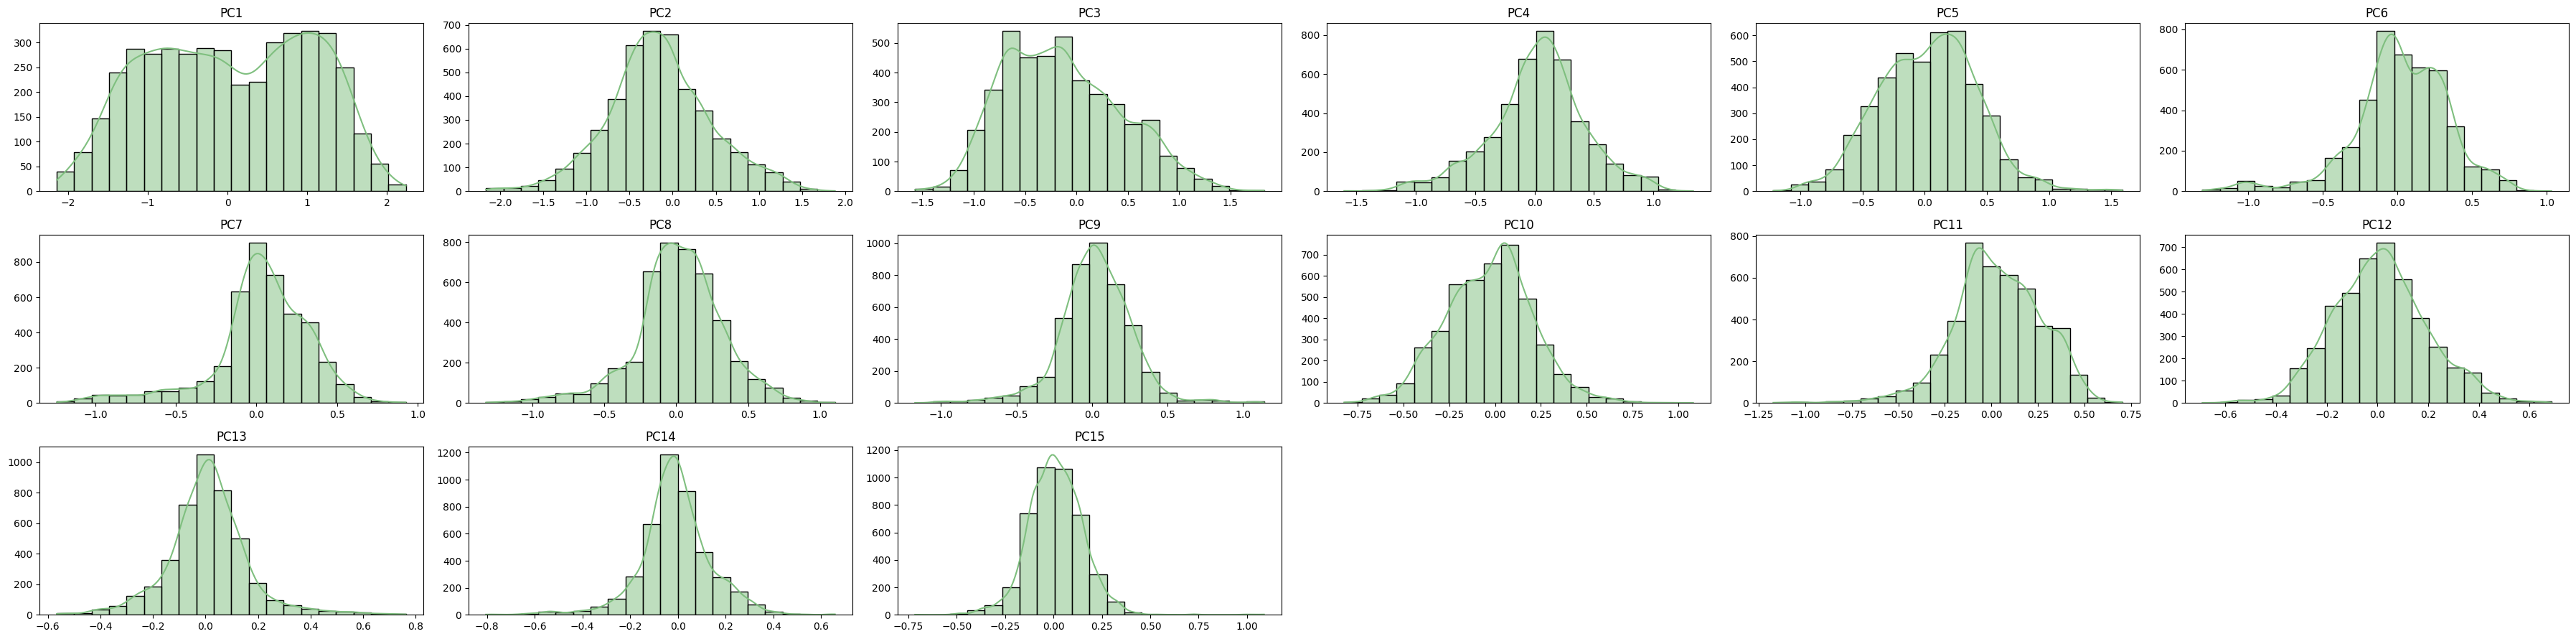

In [25]:
numerical_columns = df_balanced.select_dtypes(include = ['int', 'float']).columns
# Compute grid size
n = len(numerical_columns)
ncols = 6
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
axes = axes.flatten()

# Plot each histogram
for ax, col in zip(axes, numerical_columns):
    sns.histplot(df_balanced[col].dropna(), kde=True, bins=20, ax=ax, color='#7fbf7f')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Turn off any unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Despite having applied oversampling, our dataset continues to exhibit healthy distributional properties: the principal components remain well‐centered, and skewness across most features falls within acceptable bounds. With these preprocessing steps in place, we can confidently proceed to train our model and begin evaluating its performance.


# Conclusion
Through a data‐driven exploratory analysis and a review of established practices in the literature, we have defined a straightforward yet robust preprocessing pipeline to build the foundations of a high‐quality gesture dataset and predictive model. By filtering out low-variance features, applying a Yeo-Johnson power transform to correct skewness, and leveraging PCA for dimensionality reduction, we retained only the most informative signals. SMOTE was employed to address class imbalance, with the understanding that alternative resampling techniques may be explored as the project evolves.

Our approach emphasizes continual experimentation—each decision was justified by the underlying data distributions, and future iterations will reassess these choices as more samples become available. Expanding the dataset remains a top priority: as new annotations are gathered, we will rerun EDA, adjust our cleaning and normalization steps, and, if necessary, refine our feature‐engineering strategy. In the long term, this iterative cycle of data collection and model refinement will support a real-time translation application, helping to bridge the communication gap between the deaf community and the hearing world.